In [ ]:
import os
import glob
import random
import torch
import numpy as np
import SimpleITK as sitk
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

class PICAI_Dataset(Dataset):
    def __init__(self, image_root, label_root, transform=None):
        self.image_root = image_root
        self.label_root = label_root
        self.transform = transform

        # Collect list of (image_path, label_path) pairs
        self.data_pairs = []
        for case_dir in sorted(os.listdir(image_root)):
            case_path = os.path.join(image_root, case_dir)
            t2w_files = glob.glob(os.path.join(case_path, "*_t2w.mha"))
            for t2w_path in t2w_files:
                filename = os.path.basename(t2w_path).replace("_t2w.mha", "")
                label_path = os.path.join(label_root, f"{filename}.nii.gz")
                if os.path.exists(label_path):
                    self.data_pairs.append((t2w_path, label_path))

    def __len__(self):
        return len(self.data_pairs)

    def __getitem__(self, idx):
        t2w_path, label_path = self.data_pairs[idx]

        t2w = sitk.GetArrayFromImage(sitk.ReadImage(t2w_path)).astype(np.float32)
        label = sitk.GetArrayFromImage(sitk.ReadImage(label_path)).astype(np.uint8)

        t2w = (t2w - np.mean(t2w)) / np.std(t2w)
        t2w = torch.tensor(t2w).unsqueeze(0)  # shape: [1, D, H, W]
        label = torch.tensor(label)

        if self.transform:
            t2w, label = self.transform(t2w, label)

        return t2w, label

    def display_random_samples(self, n=5):
        sample_indices = random.sample(range(len(self)), n)
        for i, idx in enumerate(sample_indices):
            t2w, label = self[idx]  # [1, D, H, W] and [D, H, W] # <-- calls self.__getitem__(idx)
            print(f"Sample {idx}: T2W shape: {t2w.shape}, Label shape: {label.shape}")

            mid_slice = t2w.shape[1] // 2
            img = t2w[0, mid_slice].numpy()
            mask = label[mid_slice].numpy()

            fig, axs = plt.subplots(1, 2, figsize=(8, 4))
            axs[0].imshow(img, cmap='gray')
            axs[0].set_title(f'Sample {idx} - T2W')
            axs[1].imshow(mask, cmap='Reds')
            axs[1].set_title(f'Sample {idx} - Mask')
            plt.tight_layout()
            plt.show()

    
    def display_random_samples2(self, n=5):
        sample_indices = random.sample(range(len(self)), n)
        for i, idx in enumerate(sample_indices):
            t2w, label = self[idx]  # t2w: [1, D, H, W], label: [D, H, W]

            mid_slice = t2w.shape[1] // 2
            img = t2w[0, mid_slice].numpy()
            mask = label[mid_slice].numpy()

            fig, ax = plt.subplots(figsize=(6, 6))
            ax.imshow(img, cmap='gray')
            ax.imshow(mask, cmap='Reds', alpha=0.4)  # overlay with transparency
            ax.set_title(f'Sample {idx}: T2W with Mask Overlay')
            ax.axis('off')
            plt.tight_layout()
            plt.show()

dataset = PICAI_Dataset(
    image_root="input/images",
    label_root="input/picai_labels/csPCa_lesion_delineations/human_expert/resampled"
)

Sample 1285: T2W shape: torch.Size([1, 19, 640, 640]), Label shape: torch.Size([19, 640, 640])


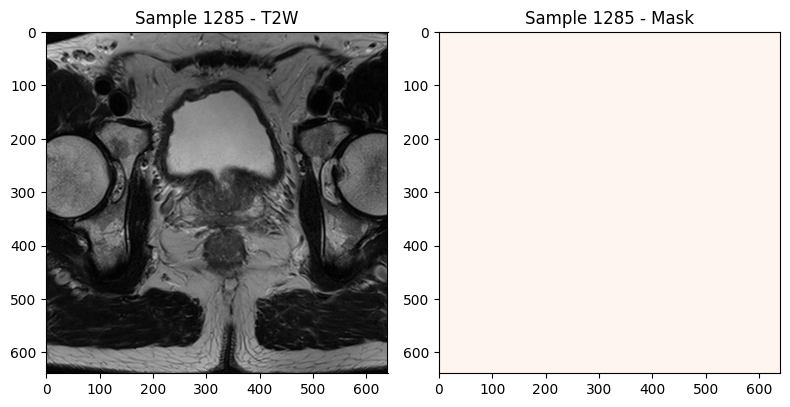

Sample 694: T2W shape: torch.Size([1, 27, 1024, 1024]), Label shape: torch.Size([27, 1024, 1024])


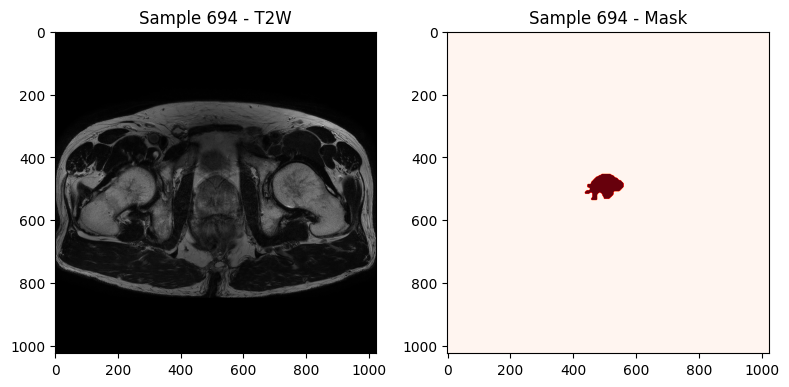

Sample 953: T2W shape: torch.Size([1, 19, 320, 320]), Label shape: torch.Size([19, 320, 320])


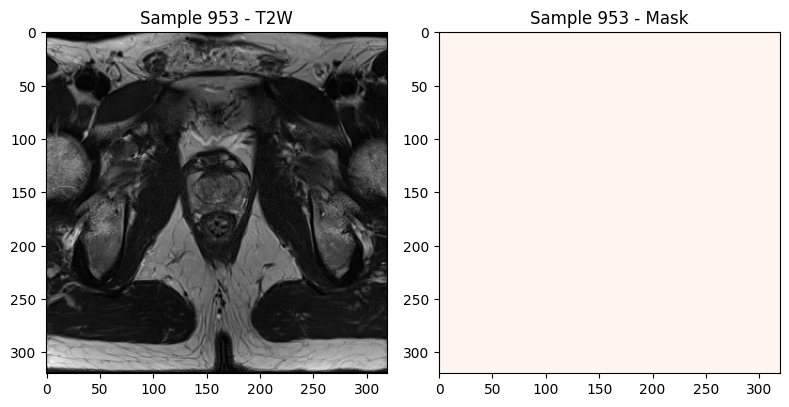

Sample 177: T2W shape: torch.Size([1, 23, 640, 640]), Label shape: torch.Size([23, 640, 640])


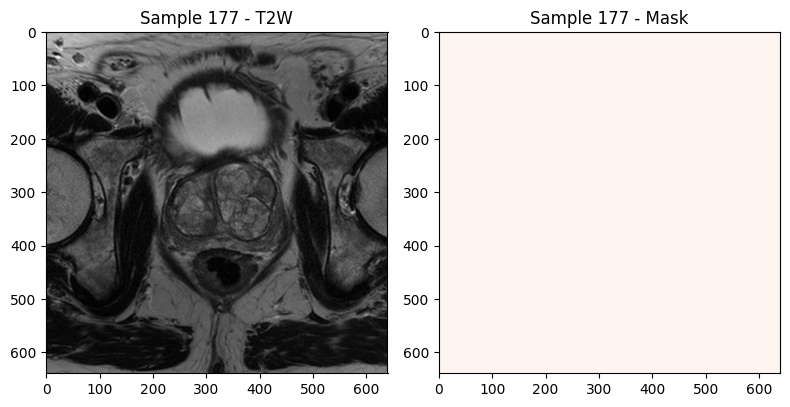

Sample 1190: T2W shape: torch.Size([1, 21, 640, 640]), Label shape: torch.Size([21, 640, 640])


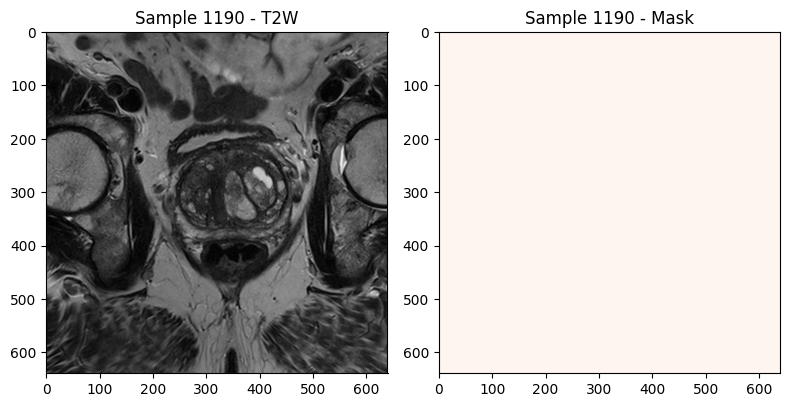

In [15]:
dataset.display_random_samples(n=5)

In [ ]:
dataset.display_random_samples2(n=5)

In [13]:
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = self.conv_block(1, 32)
        self.enc2 = self.conv_block(32, 64)
        self.pool = nn.MaxPool2d(2)
        self.up = nn.Upsample(scale_factor=2)
        self.dec1 = self.conv_block(64, 32)
        self.out = nn.Conv2d(32, 2, kernel_size=1)

    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        d1 = self.dec1(self.up(e2))
        out = self.out(d1 + e1)  # skip connection
        return out


In [16]:
from torch.utils.data import DataLoader
import torch.optim as optim

#dataset = PICAI_Dataset("PI-CAI/train")
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(5):
    model.train()
    total_loss = 0
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        output = model(x)
        loss = criterion(output, y.long())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


RuntimeError: stack expects each tensor to be equal size, but got [1, 21, 384, 384] at entry 0 and [1, 33, 384, 384] at entry 1

In [ ]:
import os
import SimpleITK as sitk
import numpy as np

def get_annotated_positive_cases(image_root, label_root):
    """
    Returns list of (image_path, label_path) for only the cases that contain csPCa lesions (labels with values 2-5).
    """
    annotated_cases = []

    for filename in os.listdir(label_root):
        if not filename.endswith(".nii.gz"):
            continue

        label_path = os.path.join(label_root, filename)
        label = sitk.GetArrayFromImage(sitk.ReadImage(label_path)).astype(np.uint8)

        if np.any(np.isin(label, [2, 3, 4, 5])):
            # Reconstruct image path based on naming
            case_id = filename.replace(".nii.gz", "")
            pid, sid = case_id.split("_")
            image_path = os.path.join(image_root, pid, f"{pid}_{sid}_t2w.mha")

            if os.path.exists(image_path):
                annotated_cases.append((image_path, label_path))
            else:
                print(f"Image not found for case: {case_id}")

    print(f"Total annotated positive cases found: {len(annotated_cases)}")
    return annotated_cases



In [3]:
image_root = "input/images"
label_root = "input/picai_labels/csPCa_lesion_delineations/human_expert/original"

annotated_positive_cases = get_annotated_positive_cases(image_root, label_root)

# Preview first 3
for img, lbl in annotated_positive_cases[:3]:
    print(f"Image: {img}")
    print(f"Label: {lbl}")


Total annotated positive cases found: 220
Image: input/images/10005/10005_1000005_t2w.mha
Label: input/picai_labels/csPCa_lesion_delineations/human_expert/original/10005_1000005.nii.gz
Image: input/images/10012/10012_1000012_t2w.mha
Label: input/picai_labels/csPCa_lesion_delineations/human_expert/original/10012_1000012.nii.gz
Image: input/images/10019/10019_1000019_t2w.mha
Label: input/picai_labels/csPCa_lesion_delineations/human_expert/original/10019_1000019.nii.gz


In [ ]:
import os
import pandas as pd
import numpy as np
import SimpleITK as sitk

# === INPUT PATHS ===
metadata_csv = "input/picai_labels/clinical_information/marksheet.csv"
image_root="input/images"
label_root = "input/picai_labels/csPCa_lesion_delineations/human_expert/resampled"

# === LOAD CSV ===
df = pd.read_csv(metadata_csv)
df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns]


# Add unique case_id column = patient_id_study_id
df["case_id"] = df["patient_id"].astype(str) + "_" + df["study_id"].astype(str)

# Filter only csPCa positive cases (i.e., those marked YES)
positive_cases = df[df["case_cspca"].str.upper() == "YES"].copy()

# === CLASSIFY INTO ANNOTATED AND UNANNOTATED ===
annotated_ids = []
unannotated_ids = []

for _, row in positive_cases.iterrows():
    cid = row["case_id"]
    mask_path = os.path.join(label_root, f"{cid}.nii.gz")

    if not os.path.exists(mask_path):
        unannotated_ids.append(cid)
        continue

    try:
        label = sitk.GetArrayFromImage(sitk.ReadImage(mask_path)).astype(np.uint8)
        if np.any(np.isin(label, [2, 3, 4, 5])):
            annotated_ids.append(cid)
        else:
            unannotated_ids.append(cid)
    except Exception as e:
        print(f"Error reading {cid}: {e}")
        unannotated_ids.append(cid)

# === CREATE FINAL DATAFRAMES ===
annotated_df = positive_cases[positive_cases["case_id"].isin(annotated_ids)].copy()
unannotated_df = positive_cases[positive_cases["case_id"].isin(unannotated_ids)].copy()

# === SAVE OR DISPLAY ===
print(f"✅ Annotated csPCa cases: {len(annotated_df)}")
print(f"❌ Unannotated csPCa cases: {len(unannotated_df)}")

# Optional: save as CSV
annotated_df.to_csv("annotated_cspca_cases.csv", index=False)
unannotated_df.to_csv("unannotated_cspca_cases.csv", index=False)

✅ Annotated csPCa cases: 220
❌ Unannotated csPCa cases: 205


In [ ]:
image_root = "input/images"
label_root = "input/picai_labels/csPCa_lesion_delineations/human_expert/resampled"

data_pairs = []
for case_dir in sorted(os.listdir(image_root)):
    case_path = os.path.join(image_root, case_dir)
    t2w_files = glob.glob(os.path.join(case_path, "*_t2w.mha"))
    for t2w_path in t2w_files:
        filename = os.path.basename(t2w_path).replace("_t2w.mha", "")
        label_path = os.path.join(label_root, f"{filename}.nii.gz")
        if os.path.exists(label_path):
            data_pairs.append((t2w_path, label_path))

In [16]:
len(data_pairs)

1295

In [17]:
data_pairs[:5]

[('input/images/10000/10000_1000000_t2w.mha',
  'input/picai_labels/csPCa_lesion_delineations/human_expert/original/10000_1000000.nii.gz'),
 ('input/images/10001/10001_1000001_t2w.mha',
  'input/picai_labels/csPCa_lesion_delineations/human_expert/original/10001_1000001.nii.gz'),
 ('input/images/10002/10002_1000002_t2w.mha',
  'input/picai_labels/csPCa_lesion_delineations/human_expert/original/10002_1000002.nii.gz'),
 ('input/images/10003/10003_1000003_t2w.mha',
  'input/picai_labels/csPCa_lesion_delineations/human_expert/original/10003_1000003.nii.gz'),
 ('input/images/10004/10004_1000004_t2w.mha',
  'input/picai_labels/csPCa_lesion_delineations/human_expert/original/10004_1000004.nii.gz')]

In [2]:
# Segmentation/pi-cai/data/input/images/10000/10000_1000000_t2w.mha
# input a single .mha file and convert it to np array 

import SimpleITK as sitk
import numpy as np

# Path to your .mha file
file_path = "input/images/10000/10000_1000000_t2w.mha"

# Read image using SimpleITK
sitk_image = sitk.ReadImage(file_path)

# Convert to NumPy array (Shape: [depth, height, width])
np_array = sitk.GetArrayFromImage(sitk_image)

print("Array shape:", np_array.shape)


Array shape: (31, 640, 640)


In [ ]:
# Segmentation/pi-cai/data/input/picai_labels/csPCa_lesion_delineations/human_expert/resampled/10000_1000000.nii.gz

In [3]:
import nibabel as nib
import numpy as np

# Path to your .nii.gz file
file_path = 'input/picai_labels/csPCa_lesion_delineations/human_expert/resampled/10000_1000000.nii.gz'

# Load image using nibabel
nii_image = nib.load(file_path)

# Convert to NumPy array
np_array = nii_image.get_fdata()

print("Shape of array:", np_array.shape)


Shape of array: (640, 640, 31)


In [7]:
folder_path = "input/images"  # change this to your folder of interest
num_items = len(os.listdir(folder_path))
print(f"Number of items in '{folder_path}': {num_items}")

Number of items in 'input/images': 1476


In [8]:
folder_path = "input/picai_labels/csPCa_lesion_delineations/human_expert/resampled"  # change this to your folder of interest
num_items = len(os.listdir(folder_path))
print(f"Number of items in '{folder_path}': {num_items}")

Number of items in 'input/picai_labels/csPCa_lesion_delineations/human_expert/resampled': 1295


In [9]:
folder_path = "input/picai_labels/csPCa_lesion_delineations/human_expert/original"  # change this to your folder of interest
num_items = len(os.listdir(folder_path))
print(f"Number of items in '{folder_path}': {num_items}")

Number of items in 'input/picai_labels/csPCa_lesion_delineations/human_expert/original': 1295


In [10]:
folder_path = "input/picai_labels/csPCa_lesion_delineations/AI/Bosma22a"  # change this to your folder of interest
num_items = len(os.listdir(folder_path))
print(f"Number of items in '{folder_path}': {num_items}")

Number of items in 'input/picai_labels/csPCa_lesion_delineations/AI/Bosma22a': 1501


In [4]:
import os
import pandas as pd
import SimpleITK as sitk
import nibabel as nib
import numpy as np

# Your folder paths
img_root = "input/images"
mask_root = "input/picai_labels/csPCa_lesion_delineations/human_expert/resampled"

records = []

for patient_id in sorted(os.listdir(img_root)):
    img_dir = os.path.join(img_root, patient_id)
    if not os.path.isdir(img_dir):
        continue

    for f in os.listdir(img_dir):
        if not f.endswith('.mha'):
            continue

        study_id = f.replace('_t2w.mha', '')
        img_path = os.path.join(img_dir, f)
        mask_path = os.path.join(mask_root, study_id + '.nii.gz')

        if not os.path.exists(mask_path):
            continue

        try:
            # Load image and mask
            img = sitk.GetArrayFromImage(sitk.ReadImage(img_path))
            mask = nib.load(mask_path).get_fdata()
            mask = np.transpose(mask, (2, 0, 1)) if mask.shape != img.shape else mask

            records.append({
                'study_id': study_id,
                'image_shape': img.shape,
                'mask_shape': mask.shape,
                'dims_match': img.shape == mask.shape
            })

        except Exception as e:
            print(f"Skipping {study_id}: {str(e)}")

# Create dataframe
df = pd.DataFrame(records)
df


,study_id,image_shape,mask_shape,dims_match
0,10000_1000000,"(31, 640, 640)","(31, 640, 640)",True
1,10001_1000001,"(21, 640, 640)","(21, 640, 640)",True
2,10002_1000002,"(22, 384, 384)","(22, 384, 384)",True
3,10003_1000003,"(23, 384, 384)","(23, 384, 384)",True
4,10004_1000004,"(21, 640, 640)","(21, 640, 640)",True
...,...,...,...,...
1290,11470_1001494,"(27, 384, 384)","(27, 384, 384)",True
1291,11471_1001495,"(19, 384, 384)","(19, 384, 384)",True
1292,11473_1001497,"(21, 640, 640)","(21, 640, 640)",True
1293,11474_1001498,"(23, 320, 320)","(23, 320, 320)",True


In [5]:
df.to_csv("image_and_mask_shapes.csv", index=False)

In [6]:
df.groupby('dims_match').size()

dims_match
True    1295
dtype: int64

In [8]:
import os
import numpy as np
import nibabel as nib
import SimpleITK as sitk
import pandas as pd

img_root = "input/images"
mask_root = "input/picai_labels/csPCa_lesion_delineations/human_expert/resampled"
exclude_csv = "unannotated_cspca_cases.csv"

excluded = set(pd.read_csv(exclude_csv)['study_id'].astype(str).tolist())
max_h, max_w = 0, 0

for patient_folder in sorted(os.listdir(img_root)):
    patient_path = os.path.join(img_root, patient_folder)
    if not os.path.isdir(patient_path):
        continue

    for file in os.listdir(patient_path):
        if not file.endswith("_t2w.mha"):
            continue

        study_id = file.replace("_t2w.mha", "")
        if study_id in excluded:
            continue

        img_path = os.path.join(patient_path, file)
        mask_path = os.path.join(mask_root, study_id + ".nii.gz")
        if not os.path.exists(mask_path):
            continue

        try:
            img = sitk.GetArrayFromImage(sitk.ReadImage(img_path))
            mask = nib.load(mask_path).get_fdata()
            mask = np.transpose(mask, (2, 0, 1)) if mask.shape != img.shape else mask

            if img.shape != mask.shape:
                continue

            _, h, w = img.shape
            max_h = max(max_h, h)
            max_w = max(max_w, w)

        except Exception as e:
            print(f"Skipping {study_id}: {e}")

print(f"Max dimensions across dataset: height={max_h}, width={max_w}")


Max dimensions across dataset: height=1024, width=1024


In [2]:
import os
import torch
import numpy as np
import nibabel as nib
import SimpleITK as sitk
import pandas as pd
from torch.utils.data import Dataset
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

In [13]:



class ProstateSegDataset(Dataset):
    def __init__(self, img_root, mask_root, exclude_csv, transform=None):
        self.img_root = img_root
        self.mask_root = mask_root
        self.transform = transform
        self.exclude_ids = set(pd.read_csv(exclude_csv)['study_id'].astype(str).tolist())

        self.samples = []
        for patient_id in sorted(os.listdir(img_root)):
            img_files = [f for f in os.listdir(os.path.join(img_root, patient_id)) if f.endswith('.mha')]
            for f in img_files:
                study_id = f.split(".")[0]  # e.g., 10000_1000000_t2w
                base_id = study_id.replace("_t2w", "")
                if base_id in self.exclude_ids:
                    continue

                img_path = os.path.join(img_root, patient_id, f)
                mask_path = os.path.join(mask_root, base_id + ".nii.gz")
                if not os.path.exists(mask_path):
                    continue

                # Load and check shape match
                img = sitk.GetArrayFromImage(sitk.ReadImage(img_path))  # Shape: [D, H, W]
                mask = nib.load(mask_path).get_fdata()  # Shape: [H, W, D] for most NIfTI
                mask = np.transpose(mask, (2, 0, 1)) if mask.shape != img.shape else mask

                if img.shape != mask.shape:
                    continue

                self.samples.append((img_path, mask_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, mask_path = self.samples[idx]

        img = sitk.GetArrayFromImage(sitk.ReadImage(img_path)).astype(np.float32)
        mask = nib.load(mask_path).get_fdata().astype(np.float32)
        mask = np.transpose(mask, (2, 0, 1)) if mask.shape != img.shape else mask

        # Normalize and return as torch tensors (slice-by-slice if 2D)
        img = (img - img.mean()) / (img.std() + 1e-6) 
        img = np.expand_dims(img, axis=1)  # (D, 1, H, W)
        mask = np.expand_dims(mask, axis=1)

        if self.transform:
            img = self.transform(torch.tensor(img))
            mask = self.transform(torch.tensor(mask))

        return img, mask


In [7]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
import SimpleITK as sitk
import torch
from torch.utils.data import Dataset

class ProstateSegSliceDataset(Dataset):
    def __init__(self, img_root, mask_root, exclude_csv, transform=None):
        self.transform = transform
        self.slice_pairs = []

        excluded = set(pd.read_csv(exclude_csv)['study_id'].astype(str).tolist())

        for patient_id in sorted(os.listdir(img_root)):
            img_dir = os.path.join(img_root, patient_id)
            img_files = [f for f in os.listdir(img_dir) if f.endswith('.mha')]

            for f in img_files:
                study_id = f.split('.')[0].replace('_t2w', '')
                if study_id in excluded:
                    continue

                img_path = os.path.join(img_dir, f)
                mask_path = os.path.join(mask_root, study_id + '.nii.gz')
                if not os.path.exists(mask_path):
                    continue

                img_arr = sitk.GetArrayFromImage(sitk.ReadImage(img_path)).astype(np.float32)
                mask_arr = nib.load(mask_path).get_fdata().astype(np.float32)
                mask_arr = np.transpose(mask_arr, (2, 0, 1)) if mask_arr.shape != img_arr.shape else mask_arr

                if img_arr.shape != mask_arr.shape:
                    continue

                for i in range(img_arr.shape[0]):
                    self.slice_pairs.append((img_arr[i], mask_arr[i]))

    def __len__(self):
        return len(self.slice_pairs)

    def __getitem__(self, idx):
        img_slice, mask_slice = self.slice_pairs[idx]
        img_slice = np.expand_dims(img_slice, axis=0)  # (1, H, W)
        mask_slice = np.expand_dims(mask_slice, axis=0)

        img_tensor = torch.tensor(img_slice, dtype=torch.float32)
        mask_tensor = torch.tensor(mask_slice, dtype=torch.float32)

        if self.transform:
            img_tensor = self.transform(img_tensor)
            mask_tensor = self.transform(mask_tensor)

        return img_tensor, mask_tensor


In [3]:
import os
import numpy as np
import pandas as pd
import SimpleITK as sitk
import nibabel as nib
from torch.utils.data import Dataset
import torch

import torch.nn.functional as F

max_h, max_w = 1024, 1024  # Set your desired max dimensions here

def pad_to_size(tensor, target_h, target_w):
    _, h, w = tensor.shape
    pad_h = target_h - h
    pad_w = target_w - w
    pad_top = pad_h // 2
    pad_bottom = pad_h - pad_top
    pad_left = pad_w // 2
    pad_right = pad_w - pad_left
    return F.pad(tensor, (pad_left, pad_right, pad_top, pad_bottom), mode='constant', value=0)


class LazyProstateSegDataset(Dataset):
    def __init__(self, img_root, mask_root, exclude_csv, transform=None):
        self.transform = transform
        self.entries = []

        # Read excluded study IDs
        excluded = set(pd.read_csv(exclude_csv)['study_id'].astype(str).tolist())

        for patient_folder in sorted(os.listdir(img_root)):
            patient_path = os.path.join(img_root, patient_folder)
            if not os.path.isdir(patient_path):
                continue

            for f in os.listdir(patient_path):
                if not f.endswith('_t2w.mha'):
                    continue

                study_id = f.replace('_t2w.mha', '')
                if study_id in excluded:
                    continue

                img_path = os.path.join(patient_path, f)
                mask_path = os.path.join(mask_root, study_id + '.nii.gz')
                if not os.path.exists(mask_path):
                    continue

                try:
                    img_header = sitk.ReadImage(img_path)
                    img_size = img_header.GetSize()  # (W, H, D)
                    depth = img_size[2]

                    for z in range(depth):
                        self.entries.append({
                            'study_id': study_id,
                            'img_path': img_path,
                            'mask_path': mask_path,
                            'slice_idx': z
                        })

                except Exception as e:
                    print(f"[Warning] Skipping {study_id} due to header load error: {e}")

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx):
        entry = self.entries[idx]

        # Read and extract 2D slice only
        img_volume = sitk.GetArrayFromImage(sitk.ReadImage(entry['img_path']))  # shape: [D, H, W]
        mask_volume = nib.load(entry['mask_path']).get_fdata()
        mask_volume = np.transpose(mask_volume, (2, 0, 1)) if mask_volume.shape != img_volume.shape else mask_volume

        z = entry['slice_idx']
        img_slice = img_volume[z].astype(np.float32)
        mask_slice = mask_volume[z].astype(np.float32)

        # Normalize
        img_slice = (img_slice - np.mean(img_slice)) / (np.std(img_slice) + 1e-6)

        img_slice = np.expand_dims(img_slice, axis=0)
        mask_slice = np.expand_dims(mask_slice, axis=0)

        img_tensor = torch.tensor(img_slice, dtype=torch.float32)
        mask_tensor = torch.tensor(mask_slice, dtype=torch.float32)

        img_tensor = pad_to_size(img_tensor, max_h, max_w)
        mask_tensor = pad_to_size(mask_tensor, max_h, max_w)

        if self.transform:
            img_tensor = self.transform(img_tensor)
            mask_tensor = self.transform(mask_tensor)

        return img_tensor, mask_tensor


In [4]:
# ------- Model -------
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, 3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.enc1 = conv_block(1, 64)
        self.enc2 = conv_block(64, 128)
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = conv_block(128, 256)
        self.up1 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec1 = conv_block(256, 128)
        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec2 = conv_block(128, 64)
        self.out = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        b = self.bottleneck(self.pool(e2))
        d1 = self.up1(b)
        d1 = self.dec1(torch.cat([d1, e2], dim=1))
        d2 = self.up2(d1)
        d2 = self.dec2(torch.cat([d2, e1], dim=1))
        return torch.sigmoid(self.out(d2))

# ------- Dice Loss -------
def dice_loss(pred, target, smooth=1.):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return 1 - ((2. * intersection + smooth) / (pred.sum() + target.sum() + smooth))

In [5]:
# ------- Training -------
def train_model(model, dataloader, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        for img, mask in tqdm(dataloader, desc=f"Epoch {epoch+1}"):
            img, mask = img.to(device), mask.to(device)

            optimizer.zero_grad()
            output = model(img)
            loss = dice_loss(output, mask)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        print(f"Epoch {epoch+1} | Loss: {epoch_loss/len(dataloader):.4f}")
        

In [6]:
# ------- Config -------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

transform = transforms.Compose([
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# dataset = ProstateSegDataset("input/images/", 
#                              "input/picai_labels/csPCa_lesion_delineations/human_expert/resampled/", 
#                              "unannotated_cspca_cases.csv",
#                              transform=transform)

img_root = "input/images"
mask_root = "input/picai_labels/csPCa_lesion_delineations/human_expert/resampled"
exclude_csv = "unannotated_cspca_cases.csv"

#dataset = ProstateSegSliceDataset(img_root, mask_root, exclude_csv, transform=transform)
dataset = LazyProstateSegDataset(img_root, mask_root, exclude_csv, transform=transform)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

print(f"Valid samples: {len(dataset)}")

#dataset = ProstateSegDataset("data/images", "data/masks", transform=transform)
#dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


Using device: cuda
Valid samples: 29431


In [ ]:
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_model(model, dataloader, optimizer, num_epochs=5)

In [ ]:
save_path = "prostate_segmentation_unet.pth"
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

In [11]:
import os
import numpy as np
import pandas as pd
import SimpleITK as sitk
import nibabel as nib
from torch.utils.data import Dataset
import torch

class ProstateSegSliceDataset(Dataset):
    def __init__(self, img_root, mask_root, exclude_csv, transform=None):
        self.transform = transform
        self.slice_pairs = []

        # Load study IDs to exclude
        exclude_set = set(pd.read_csv(exclude_csv)['study_id'].astype(str).tolist())

        for patient_folder in sorted(os.listdir(img_root)):
            patient_path = os.path.join(img_root, patient_folder)
            if not os.path.isdir(patient_path):
                continue

            # Iterate over T2-weighted visits
            for filename in os.listdir(patient_path):
                if not filename.endswith("_t2w.mha"):
                    continue

                study_id = filename.replace("_t2w.mha", "")
                if study_id in exclude_set:
                    continue  # skip unannotated positives

                img_path = os.path.join(patient_path, filename)
                mask_path = os.path.join(mask_root, study_id + ".nii.gz")
                if not os.path.exists(mask_path):
                    continue  # mask not present

                # Load and validate shapes
                try:
                    img = sitk.GetArrayFromImage(sitk.ReadImage(img_path)).astype(np.float32)
                    mask = nib.load(mask_path).get_fdata().astype(np.float32)
                    mask = np.transpose(mask, (2, 0, 1)) if mask.shape != img.shape else mask

                    if img.shape != mask.shape:
                        continue  # mismatch

                    # Append valid slices
                    for z in range(img.shape[0]):
                        self.slice_pairs.append((img[z], mask[z]))

                except Exception as e:
                    print(f"[Warning] Skipping {study_id} due to load error: {e}")

    def __len__(self):
        return len(self.slice_pairs)

    def __getitem__(self, idx):
        img_slice, mask_slice = self.slice_pairs[idx]

        img_slice = (img_slice - np.mean(img_slice)) / (np.std(img_slice) + 1e-6)
        img_slice = np.expand_dims(img_slice, axis=0)
        mask_slice = np.expand_dims(mask_slice, axis=0)

        img_tensor = torch.tensor(img_slice, dtype=torch.float32)
        mask_tensor = torch.tensor(mask_slice, dtype=torch.float32)

        if self.transform:
            img_tensor = self.transform(img_tensor)
            mask_tensor = self.transform(mask_tensor)

        return img_tensor, mask_tensor


In [ ]:
import os
import pandas as pd
import numpy as np
import SimpleITK as sitk
import nibabel as nib
import imageio
from tqdm import tqdm

# Paths
img_root = "input/images"
mask_root = "input/picai_labels/csPCa_lesion_delineations/human_expert/resampled"
study_ids_csv = "annotated_cspca_cases.csv"  # should have a column 'study_id'
output_dir = "jpg_cancer_data"
os.makedirs(os.path.join(output_dir, "images"), exist_ok=True)
os.makedirs(os.path.join(output_dir, "masks"), exist_ok=True)


# Load study IDs
df = pd.read_csv(study_ids_csv)
study_ids = df['study_id'].astype(str).tolist()


for sid in tqdm(study_ids):
    # Define paths
    pid = sid.split('_')[0]
    mha_path = os.path.join(img_root, pid, f"{sid}_t2w.mha")
    nii_path = os.path.join(mask_root, f"{sid}.nii.gz")

    if not os.path.exists(mha_path) or not os.path.exists(nii_path):
        continue

    # Load volumes
    img_volume = sitk.GetArrayFromImage(sitk.ReadImage(mha_path)).astype(np.float32)
    mask_volume = nib.load(nii_path).get_fdata().astype(np.uint8)
    if mask_volume.shape != img_volume.shape:
        mask_volume = np.transpose(mask_volume, (2, 0, 1))

    # if img_volume.shape != mask_volume.shape:
    #     continue  # skip mismatched pairs

    # Normalize image to 0–255
    img_volume = (img_volume - img_volume.min()) / (img_volume.ptp() + 1e-6)
    img_volume = (img_volume * 255).astype(np.uint8)
    mask_volume = (mask_volume > 0).astype(np.uint8) * 255  # binarize mask

    # Save each slice
    for z in range(img_volume.shape[0]):
        img_out_path = os.path.join(output_dir, "images", f"{sid}_z{z:03d}.jpg")
        mask_out_path = os.path.join(output_dir, "masks", f"{sid}_z{z:03d}.jpg")
        imageio.imwrite(img_out_path, img_volume[z])
        imageio.imwrite(mask_out_path, mask_volume[z])
        print(f"{z} - Saved {img_out_path} and {mask_out_path}")
        
    



100%|██████████| 220/220 [00:00<00:00, 32816.95it/s]


In [ ]:
import os
import pandas as pd
import numpy as np
import SimpleITK as sitk
import nibabel as nib
import imageio
from tqdm import tqdm

# Paths
img_root = "input/images"
mask_root = "input/picai_labels/csPCa_lesion_delineations/human_expert/resampled"
csv_path = "annotated_cspca_cases.csv"
output_dir = "jpg_output"
os.makedirs(os.path.join(output_dir, "images"), exist_ok=True)
os.makedirs(os.path.join(output_dir, "masks"), exist_ok=True)

# Load patient and study pairs
df = pd.read_csv(csv_path)
df['patient_id'] = df['patient_id'].astype(str)
df['study_id'] = df['study_id'].astype(str)

for _, row in tqdm(df.iterrows(), total=len(df)):
    pid = row['patient_id']
    sid = row['study_id']
    study_key = f"{pid}_{sid}"

    #print(f"Processing {study_key}...")

    # Construct paths
    img_path = os.path.join(img_root, pid, f"{study_key}_t2w.mha")
    mask_path = os.path.join(mask_root, f"{study_key}.nii.gz")

    #print(f"Image path: {img_path}"f"\nMask path: {mask_path}")

    if not os.path.exists(img_path) or not os.path.exists(mask_path):
        continue

    try:
        # Load and align
        img = sitk.GetArrayFromImage(sitk.ReadImage(img_path)).astype(np.float32)
        mask = nib.load(mask_path).get_fdata().astype(np.uint8)
        if mask.shape != img.shape:
            mask = np.transpose(mask, (2, 0, 1))
        

        # Normalize image, binarize mask
        img = ((img - img.min()) / (img.ptp() + 1e-6) * 255).astype(np.uint8)
        mask = (mask > 0).astype(np.uint8) * 255

        # Save each slice
        for z in range(img.shape[0]):
            img_out = os.path.join(output_dir, "images", f"{study_key}_z{z:03d}.jpg")
            mask_out = os.path.join(output_dir, "masks", f"{study_key}_z{z:03d}.jpg")
            imageio.imwrite(img_out, img[z])
            imageio.imwrite(mask_out, mask[z])
        
        print(f"[Saved] {study_key} with {img.shape[0]} slices")

    except Exception as e:
        print(f"[Skipped] {study_key} due to error: {e}")

#input/images/10005/10005_1000005_t2w.mha
#input/images/10005/10005_1000005_t2w.mha

In [14]:
import SimpleITK as sitk
import numpy as np
np.bool = np.bool_ #https://stackoverflow.com/questions/74893742/how-to-solve-attributeerror-module-numpy-has-no-attribute-bool
from itkwidgets import view

img = sitk.ReadImage("input/images/10005/10005_1000005_t2w.mha")
view(image=img)


TraitError: label_image_weights shape expected to have 1 components, but got () components

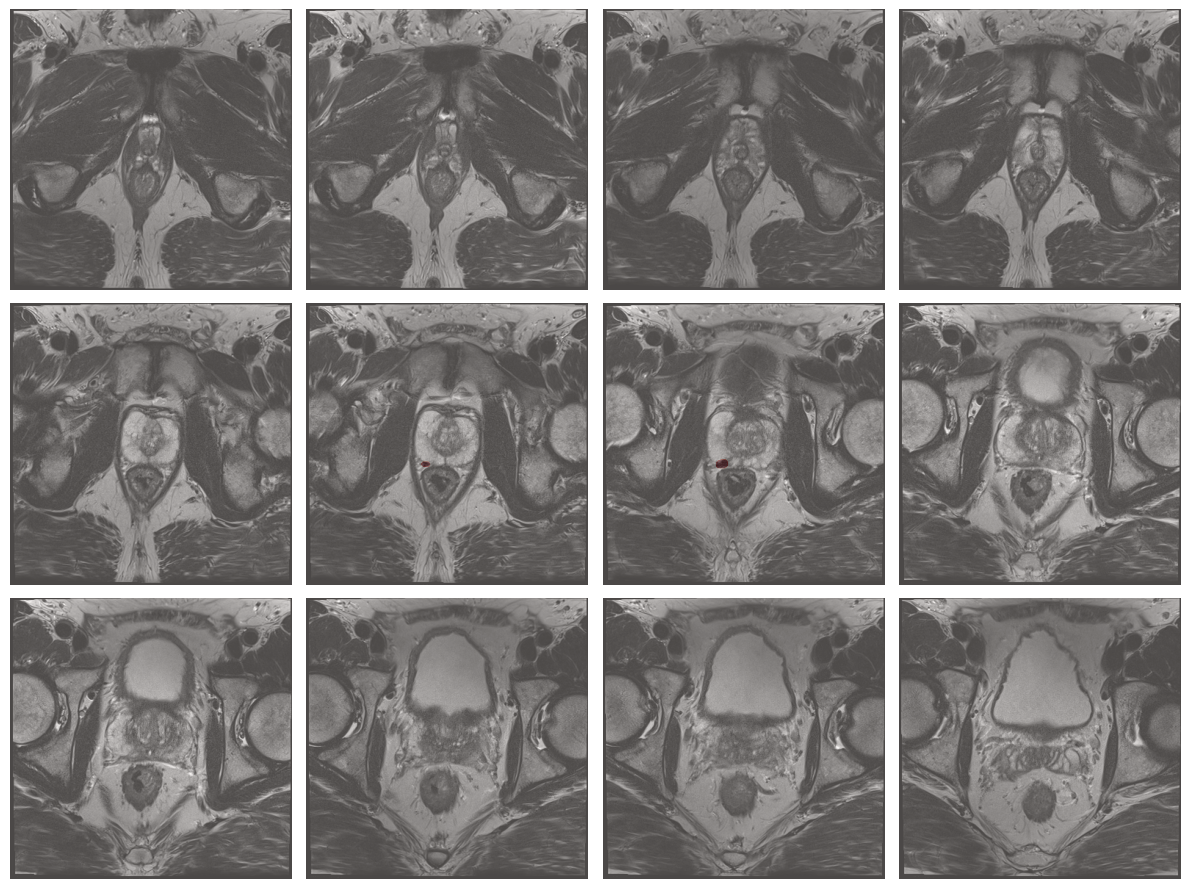

In [11]:
import matplotlib.pyplot as plt
import SimpleITK as sitk
import numpy as np

img = sitk.GetArrayFromImage(sitk.ReadImage("input/images/10005/10005_1000005_t2w.mha"))  # shape: [D, H, W]
mask = sitk.GetArrayFromImage(sitk.ReadImage("input/picai_labels/csPCa_lesion_delineations/human_expert/resampled/10005_1000005.nii.gz"))

n = 12  # Number of slices to show
fig, axs = plt.subplots(3, 4, figsize=(12, 9))
for i, ax in enumerate(axs.flat):
    idx = i * img.shape[0] // n
    ax.imshow(img[idx], cmap='gray')
    ax.imshow(mask[idx], cmap='Reds', alpha=0.3)
    ax.axis('off')
plt.tight_layout()
plt.show()
